# Импорт библиотек

In [35]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [36]:
from pylab import rcParams
rcParams['figure.figsize'] = 22, 10

# Загрузка данных
В качестве данных мы берем показатели датчиков двигателей, которые вращают шкив, измеряющий угол от 0 до 3600. В последствии, этот угол, в зависимости от кол-ва оборотов, преобразуется в позицию (в см) декорации.

In [37]:
Position_df = pd.read_csv('Position.csv',sep=',', encoding='UTF-8')
Position_df['Time'] = pd.to_datetime(Position_df['time'])

In [38]:
def print_position(df, number):
    i = 0
    while i < number:
        name = 'theatre.D'+str(i)+'_Position_AS'
        item = df[df.name == name]
        if(len(item) > 100):
            plt.plot(item.Time, item.value, label=name)
            plt.legend()
        i = i + 1

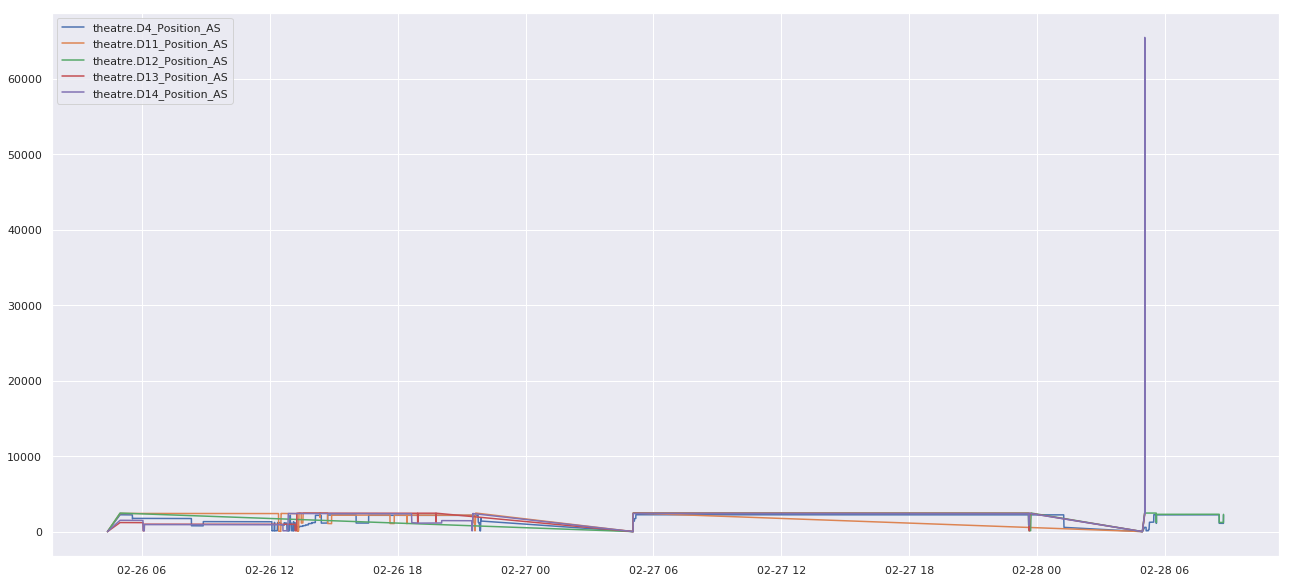

In [39]:
COUNT = 15
print_position(Position_df, COUNT)

На графике хорошо видно, что датчик на двигателе №14 имеет анамальное значение. Именно его мы и возьмем для обучения нашей модели

In [40]:
Position_D14 = Position_df[Position_df.name == 'theatre.D14_Position_AS1']
Position_D14 = pd.DataFrame(Position_D14, columns = ['Time', 'value'])
Position_D14 = Position_D14.set_index('Time')

# Подготовка данных
Определяем наборы данных для обучения и тестирования нашей модели. Разделяем наши данные на две части. Первая часть (train), в котором мы тренируемся в набора данных, которая представляет нормальные условия работы. Вторая часть (test), которая содержит аномалии.

In [41]:
train_size = int(len(Position_D14) * 0.82)
test_size = len(Position_D14) - train_size
train, test = Position_D14.iloc[2:train_size], Position_D14.iloc[train_size:len(Position_D14)]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (947, 1)
Test dataset shape: (209, 1)


# Нормализация и стандартизация данных

In [42]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [43]:
X_train.shape

(947, 1)

# Преобразование данных для LTSM
Затем мы преобразуем наши данные в формат, подходящий для ввода в сеть LSTM. Ячейки LSTM ожидают трехмерный тензор формы [выборки данных, временные шаги, особенности]

In [44]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (947, 1, 1)
Test data shape: (209, 1, 1)


# Построение нейронной сети LSTM
Для нашей модели обнаружения аномалий мы будем использовать архитектуру нейроконтроллеров с автоматическим кодированием. 
Архитектура автоэнкодера по существу изучает функцию «идентичности». Он примет входные данные, 
создаст сжатое представление основных движущих характеристик этих данных, а затем научится восстанавливать их снова. 
Основанием для использования этой архитектуры для обнаружения аномалий является то, что мы обучаем модель «нормальным» данным и определяем полученную ошибку реконструкции. 
Затем, когда модель встретит данные, которые находятся за пределами нормы, и попытается восстановить их, мы увидим увеличение ошибки восстановления,
поскольку модель никогда не обучалась для точного воссоздания элементов вне нормы.

In [45]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [46]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 1)              0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 16)             1152      
_________________________________________________________________
lstm_10 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 1)              17  

In [47]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

Train on 899 samples, validate on 48 samples
Epoch 1/100
899/899 [==============================] - 14s 16ms/step - loss: 0.3732 - val_loss: 0.7200
Epoch 2/100
899/899 [==============================] - 1s 1ms/step - loss: 0.2677 - val_loss: 0.5006
Epoch 3/100
899/899 [==============================] - 1s 2ms/step - loss: 0.1878 - val_loss: 0.1702
Epoch 4/100
899/899 [==============================] - 2s 2ms/step - loss: 0.1110 - val_loss: 0.0264
Epoch 5/100
899/899 [==============================] - 2s 2ms/step - loss: 0.0761 - val_loss: 0.0933
Epoch 6/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0706 - val_loss: 0.0648
Epoch 7/100
899/899 [==============================] - 1s 2ms/step - loss: 0.0665 - val_loss: 0.0386
Epoch 8/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0639 - val_loss: 0.1171
Epoch 9/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0618 - val_loss: 0.1205
Epoch 10/100
899/899 [======================

Epoch 81/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 82/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 83/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 84/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 85/100
899/899 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 86/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 87/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 88/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 89/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 90/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0030

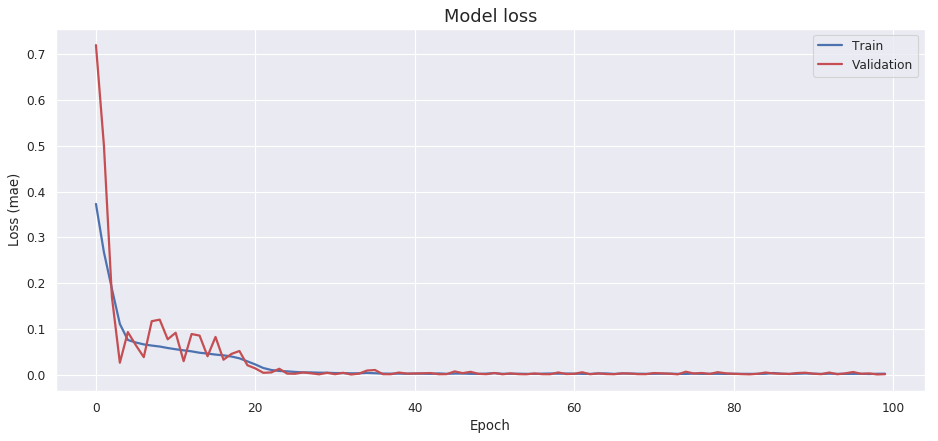

In [48]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()
fig.savefig('Model less.png')

График тренировочных потерь для оценки производительности модели

In [49]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

In [50]:
xx = X_train.reshape(X_train.shape[0], X_train.shape[2])
xx = pd.DataFrame(xx, columns=train.columns)
xx.index = train.index

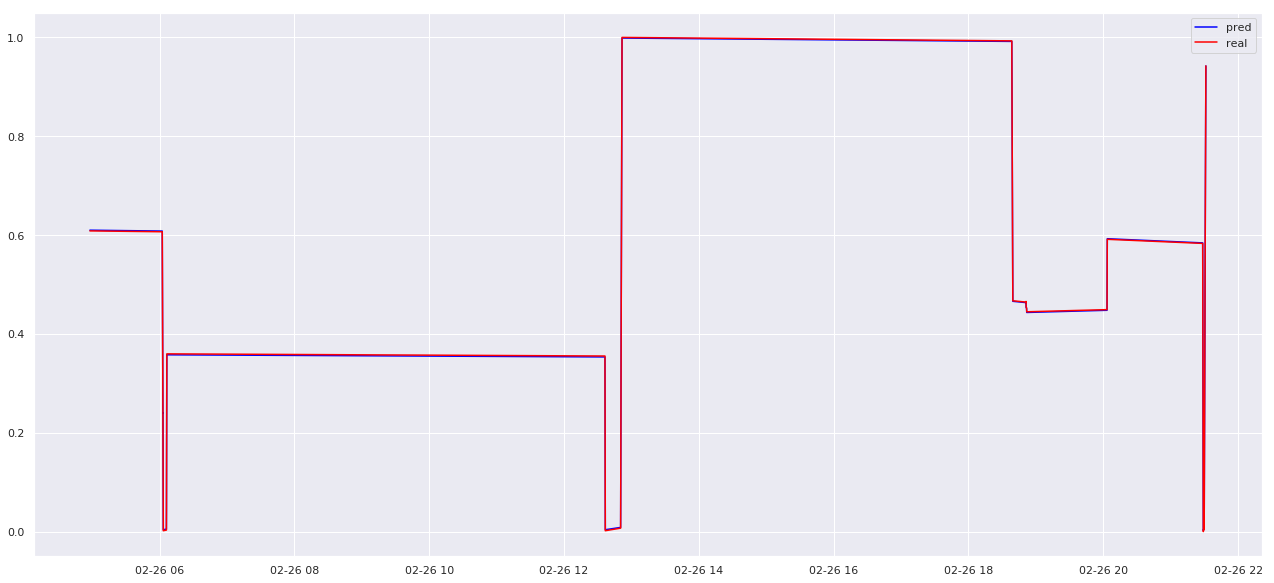

In [51]:
plt.plot(X_pred, color='blue', label='pred')
plt.plot(xx,color='red', label='real')
plt.legend()

# Распределение убытков
Составляя график распределения вычисленных потерь в обучающем наборе, мы можем определить подходящее пороговое значение для выявления аномалии.
При этом можно убедиться, что этот порог установлен выше «уровня шума», чтобы ложные срабатывания не срабатывали.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


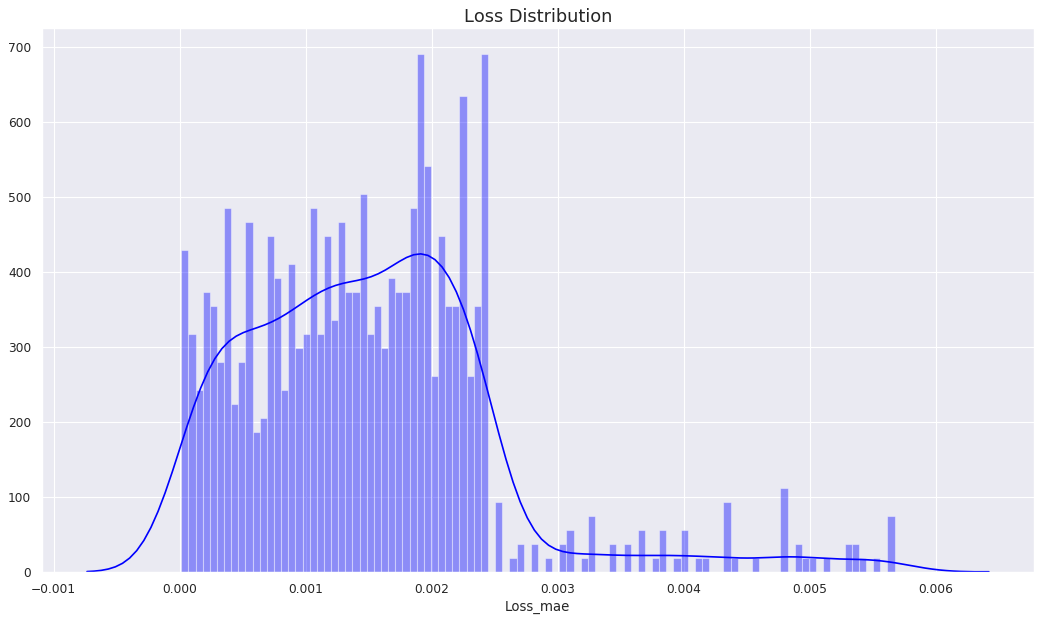

In [52]:
scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 100, kde= True, color = 'blue')
plt.savefig('Loss Distribution.png')

Исходя из приведенного выше распределения потерь, возьмем пороговое значение 0,01 для обозначения аномалии. Затем мы рассчитываем потери на реконструкцию в обучающем и тестовом наборах, чтобы определить, когда показания датчика пересекают порог аномалии.

In [53]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

In [54]:
xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
xtest = pd.DataFrame(xtest, columns=test.columns)
xtest.index = test.index

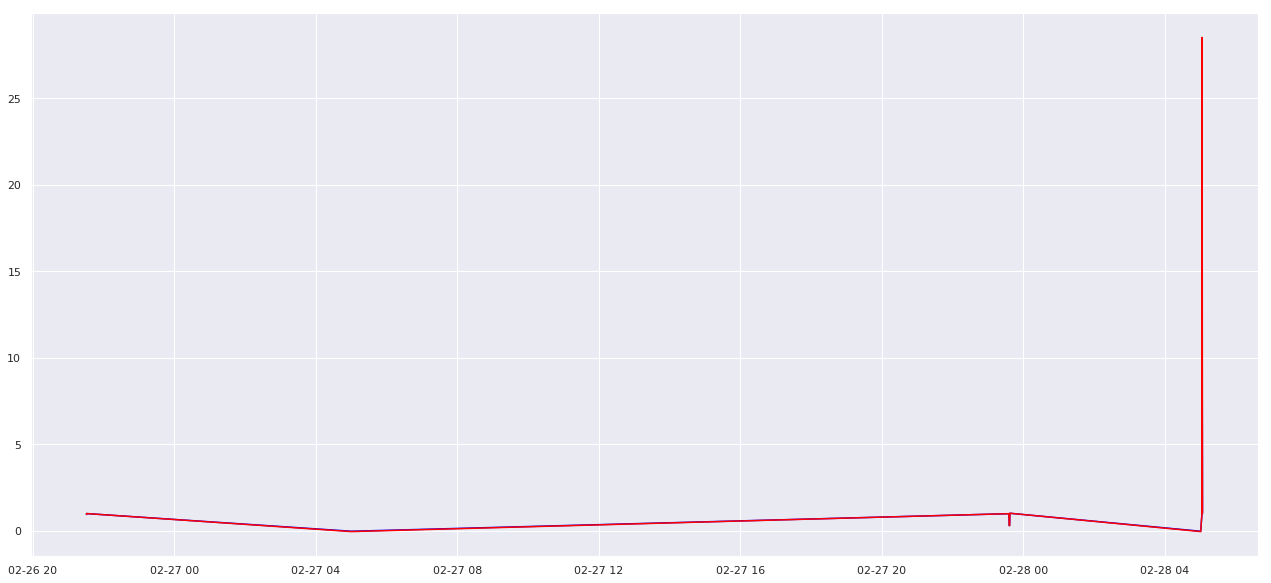

In [59]:
plt.plot(X_pred, color='blue')
plt.plot(xtest,color='red')
plt.savefig('Prediction.png')

# Аномалии

In [60]:
scored_test = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored_test['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored_test['Threshold'] = 0.01
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']
# scored['value'] = test.value
scored_test.head()

,Loss_mae,Threshold,Anomaly
Time,,,
2020-02-26 21:31:23.082,0.000133,0.01,False
2020-02-26 21:31:23.461,0.000188,0.01,False
2020-02-26 21:31:23.843,0.000335,0.01,False
2020-02-26 21:31:24.598,0.000428,0.01,False
2020-02-26 21:31:24.976,0.000579,0.01,False


In [61]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.01
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
# scored_train['value'] = train.value
scored = pd.concat([scored_train, scored_test])

Чтобы визуализировать результаты с течением времени. Красная линия указывает на наше пороговое значение 0,01.

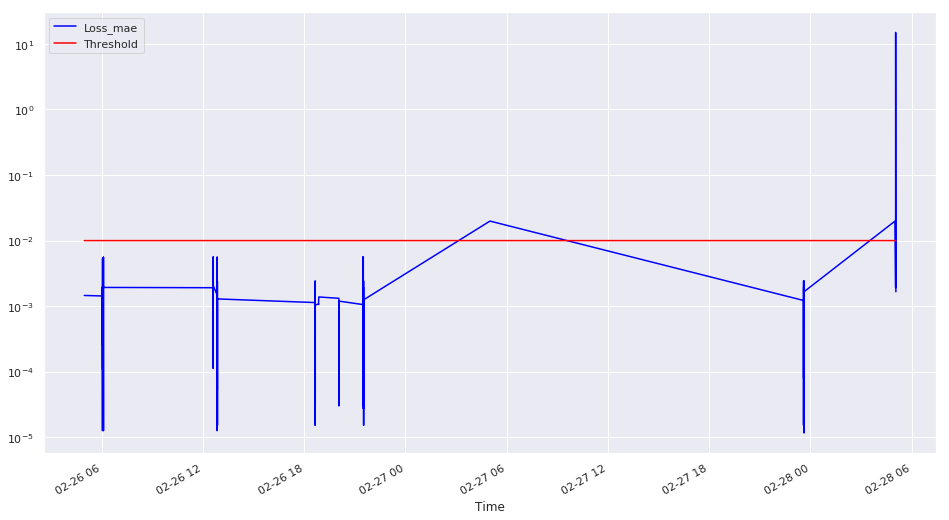

In [62]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), color=['blue','red'])
plt.savefig('Threshold.png')

In [63]:
test_score_df = scored_test
test_score_df['value'] = test.value

In [64]:
anomalies = test_score_df[test_score_df.Anomaly == True]
anomalies

,Loss_mae,Threshold,Anomaly,value
Time,,,,
2020-02-27 05:00:34.990,0.019843,0.01,True,0
2020-02-28 05:01:01.439,0.019843,0.01,True,0
2020-02-28 05:01:01.439,0.019843,0.01,True,0
2020-02-28 05:03:12.338,14.949036,0.01,True,65436
2020-02-28 05:03:12.715,14.949734,0.01,True,65439
2020-02-28 05:03:15.981,14.950448,0.01,True,65442
2020-02-28 05:03:16.358,14.949734,0.01,True,65439
2020-02-28 05:03:16.736,14.950448,0.01,True,65442
2020-02-28 05:03:17.120,14.949734,0.01,True,65439


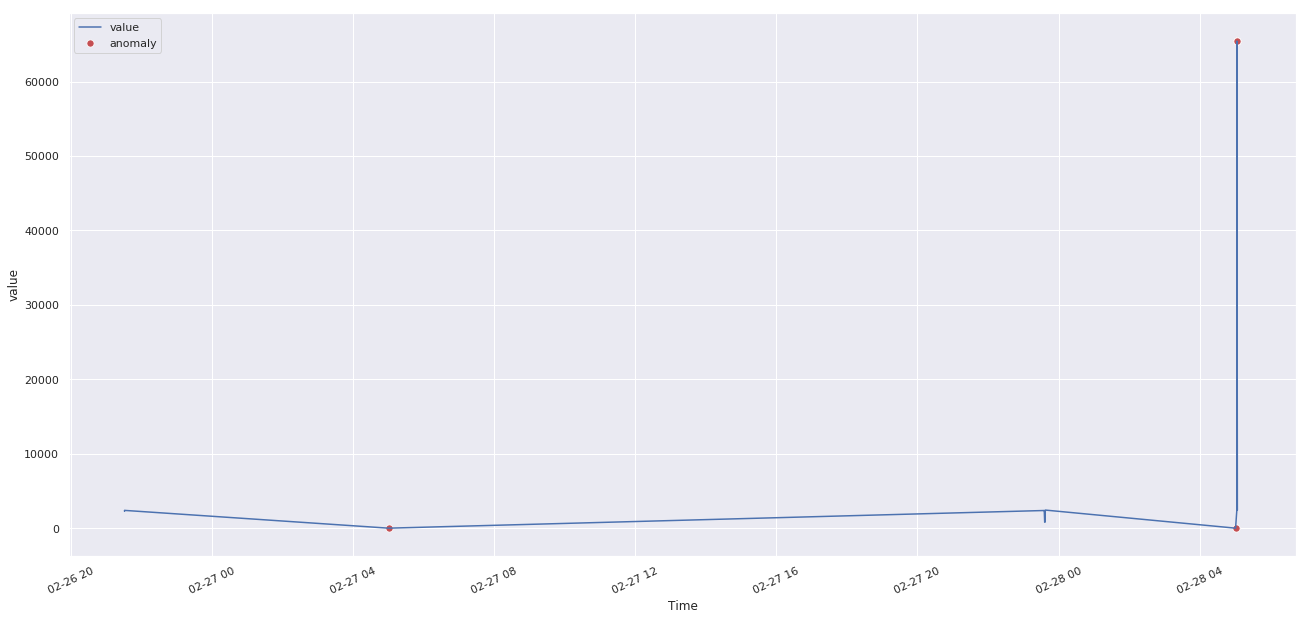

In [65]:
plt.plot(
  test.index, 
  test.value, 
  label='value'
)

sns.scatterplot(
  anomalies.index,
  anomalies.value,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend()
plt.savefig('Anomalies.png')

по графику видно, какие значения двигателя приводят к анамалии, а значит в дальyейшем мы можем заранее определять по первым показателям, когда у нас возникают анамалии

In [66]:
model.save('model.h5')